# EEG PreProcessing for Hyper Alignment Project

Try stuff. 

ToDo:
- Sanity check ordering of pre-processing
- finish up to run ICA & AutoReject & bad channels
- add selection of only correct trials
- drop the empty channels
- make this feature agnostic [0.1-30]

- Note: need to enforce the same number of trials per condtion per subject
    - Minimum accuracy, per condition
        - Subject below (in any condition): dropped
    - End point: n trials cond A, m trials cond B, ...., 
        - Each subject has the same n * m * sampling_rate length 2D matrix

In [1]:
%matplotlib inline

import os
import csv
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import mne

In [2]:
# ## Functions
# def org_files(files):
#     """Get the preprocessed, EEG data file names (csv format) a specified subject."""

#     eeg = [fi for fi in files if 'events' not in fi]
#     evs = [fi for fi in files if 'events' in fi]

#     # Quick hack to ignore subjs with problematic files
#     if not len(eeg) == len(evs):
#         print('Oh Shit. Something seems to have gone wrong.')
#         return None, None

#     return eeg, evs

def get_files(files, seq):
    """Return specified file type from list of files.
    Note: scrappy implementation - returns only first found file that matches pattern. 
    """
    
    for file in files:
        if seq in file:
            return file

## Load Data

Dataset description:

The EEG data used is a database collected and made available by the Child Mind Institute.

It is part of the Multimodal Resource for Studying Information Processing in the Developing Brain (MIPDB) database.

MIPDB Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/

EEG Data Link: http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/eeg.html

In [3]:
# Set data path
data_path = '/home/andrew/HyperEEG_Data/'

# Set subject to load
subj = 'A00062279'
subj_path = os.path.join(data_path, subj, 'EEG', 'raw', 'raw_format')

# Get list of subject files
subj_files = os.listdir(subj_path)

# Restrict to only data files (avoids hidden files, etc)
subj_files = [file for file in subj_files if '.raw' in file]
subj_files

['A00062279010.raw',
 'A00062279003.raw',
 'A00062279.raw.IMP',
 'A00062279.raw.GAIN',
 'A00062279012.raw',
 'A00062279002.raw',
 'A00062279009.raw',
 'A00062279011.raw',
 'A00062279007.raw',
 'A00062279008.raw',
 'A00062279005.raw',
 'A00062279001.raw',
 'A00062279004.raw']

In [4]:
f_nums = ['06.raw', '08.raw', '10.raw'] # note: in general, this should be read from a file, post FileOrg steps

raws = []
for f_num in f_nums:
    try:
        raw_file = get_files(subj_files, f_num)
        raws.append(mne.io.read_raw_egi(os.path.join(subj_path, raw_file), preload=True, verbose=False))
    except:
        pass

if len(raws) == 0:
    raise ValueError('There are no valid blocks for this subject.')

In [5]:
# # Sanity check consistency
# for raw in raws:
#     if raw.event_id != event_mapping:
#         print(raw.event_id)
#         raise ValueError("WARNING: event mapping issue.")

In [6]:
# Check event codes present from the file
set(mne.find_events(raws[0])[:, 2])

73 events found
Event IDs: [1 2 3 4 5]


{1, 2, 3, 4, 5}

## Set up Data


### Montage

The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.


<ipython-input-7-78e2a63dc0a7>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)
<ipython-input-7-78e2a63dc0a7>:5: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['E129']. Their position has been left untouched.
  raw.set_montage(montage)


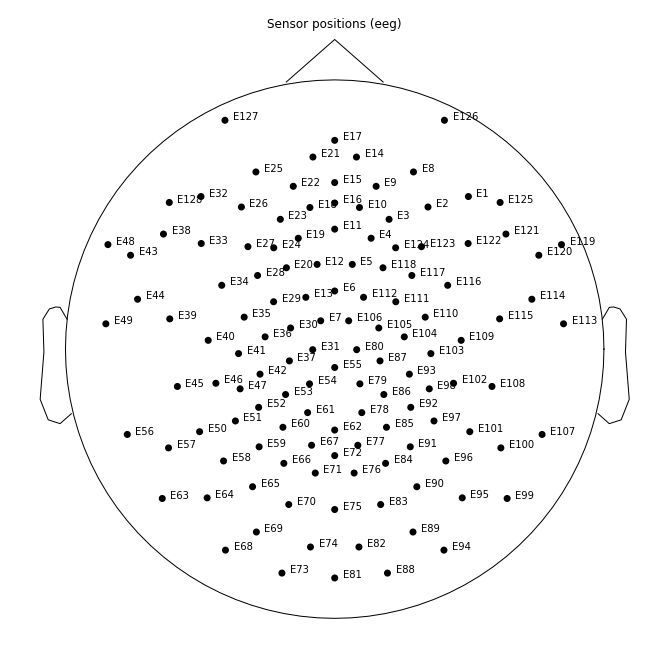

In [7]:
# Load standard montage, drop misc channels, and display channel locations
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=raws[0].ch_names)

for raw in raws:
    raw.set_montage(montage)
    raw.drop_channels(raw.ch_names[128:-1])
    
fig, ax = plt.subplots(figsize=[9, 9]);
raws[0].plot_sensors(show_names=True, axes=ax);

## Inspect data

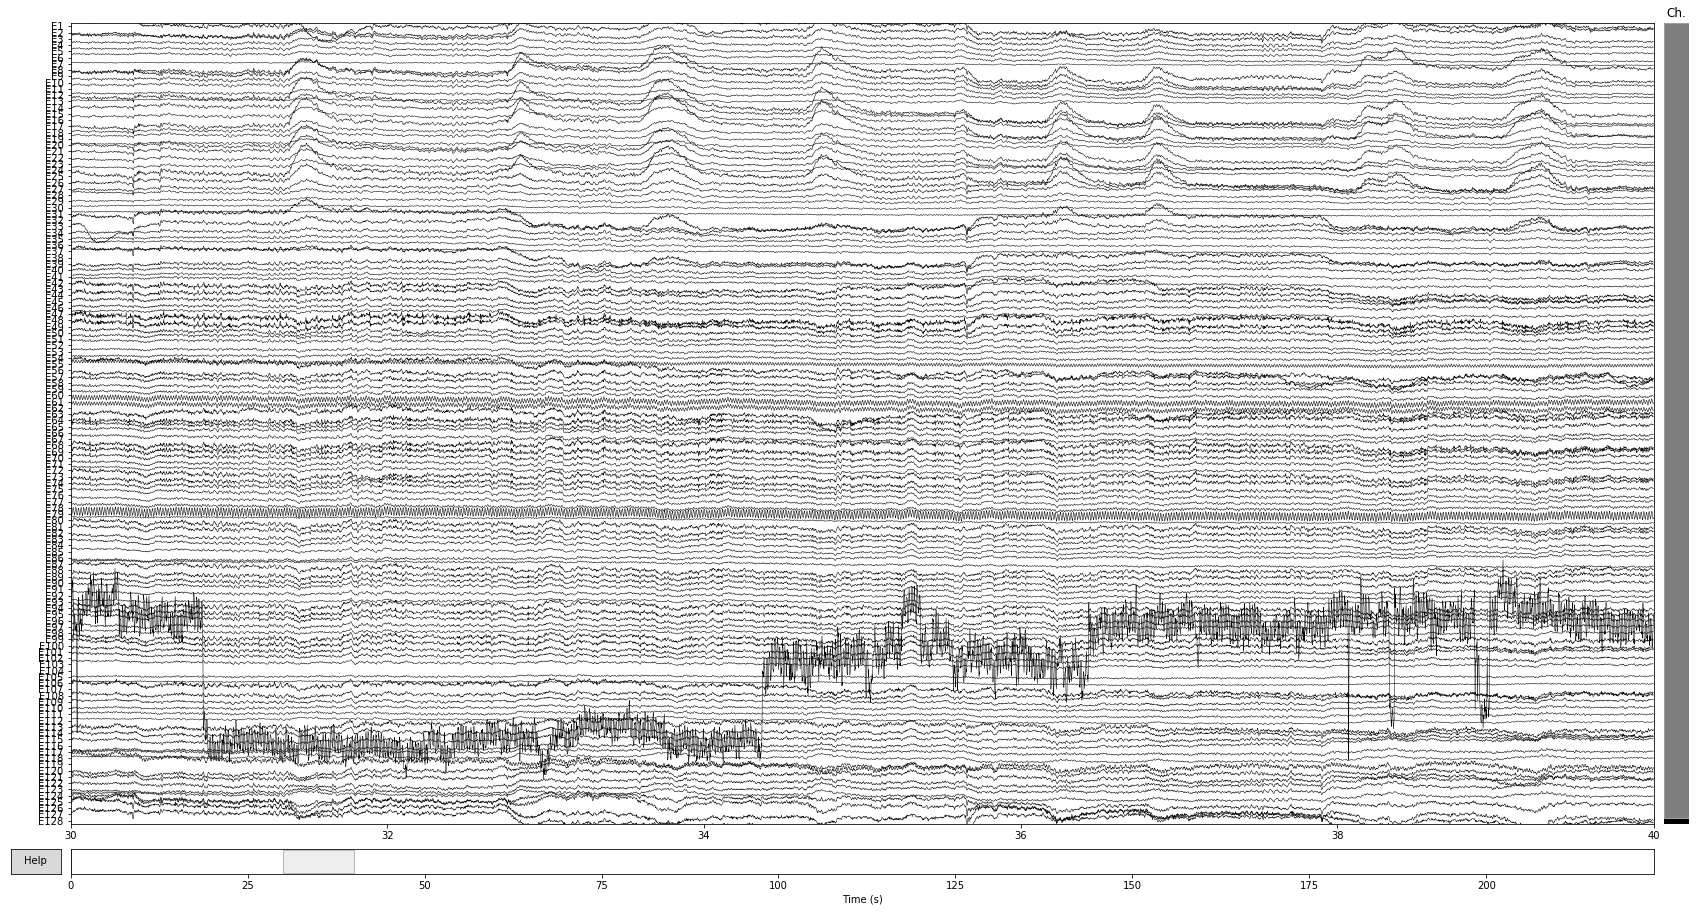

In [8]:
# Print out a small snippet of data
raws[0].plot(events=None, duration=10., start=30., n_channels=128);

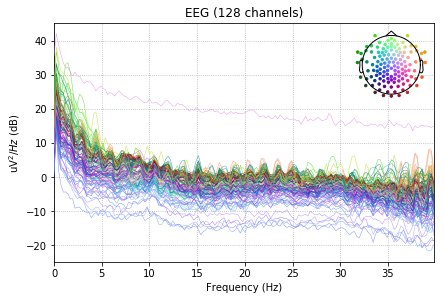

In [9]:
# Check the power spectrum of each channel
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True);

## Pre-Processing

Run pre-processing on the data. 

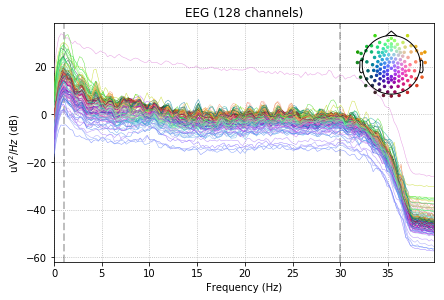

In [10]:
# High pass filter and sanity check
for raw in raws:
    raw.filter(l_freq=1., h_freq=30., fir_design='firwin', verbose=False)
raws[0].plot_psd(tmin=30, fmin=0, fmax=40, dB=True);

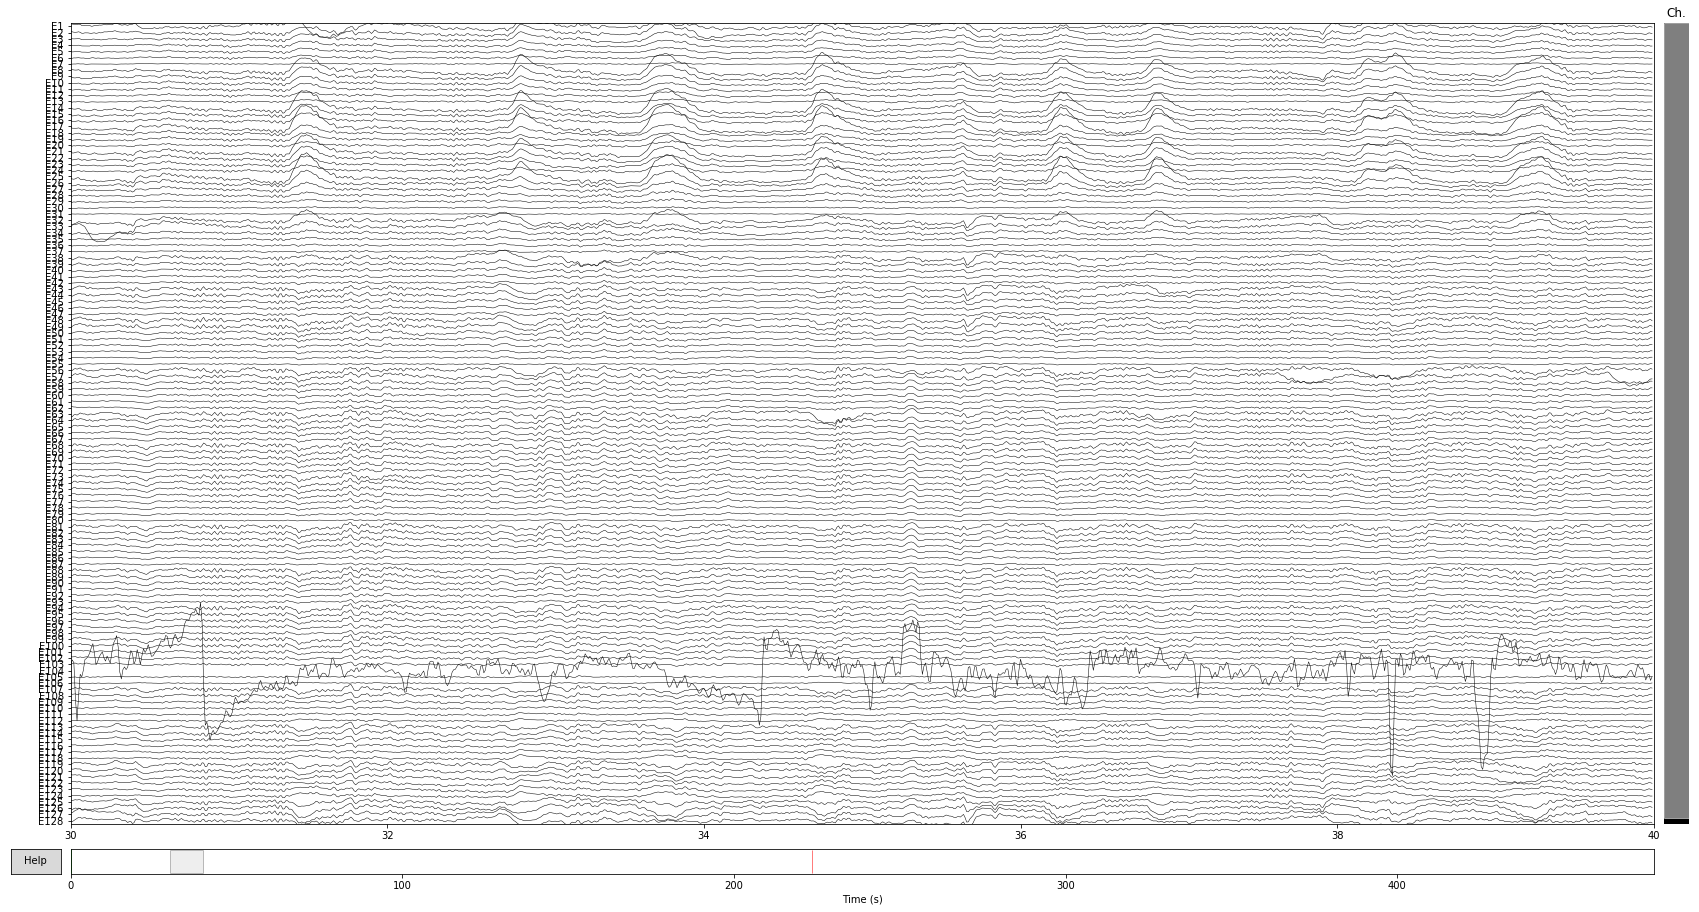

In [11]:
# Combine raw objects into a new, single raw object, and check filtering in time domain
raw = mne.concatenate_raws(raws)
raw.plot(events=None, duration=10., start=30., n_channels=128);

### Events & Epoching

Event code descriptions:
- 3 :  5  = start trial
- 4 :  8  = Target ON left
- 5 :  9  = Target ON right
- 1 : 12  = button press left
- 2 : 13  = button press right

Counter({3: 50, 2: 25, 1: 25, 5: 24, 4: 24})


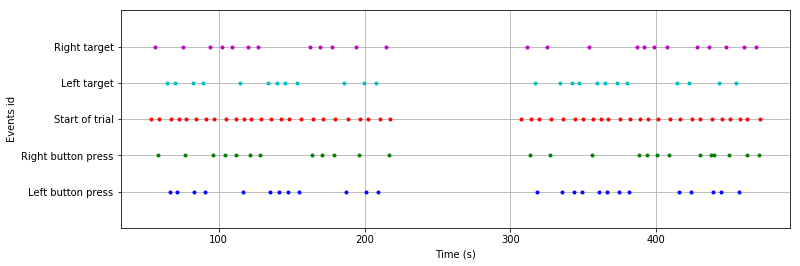

In [12]:
# Check events and codes
events = mne.find_events(raw, verbose=False)
print(Counter(events[:, 2]))

fig, ax = plt.subplots(figsize=[12, 4])
_ = mne.viz.plot_events(events, raw.info['sfreq'], axes=ax, show=False)
ax.set_yticklabels(['Left button press', 'Right button press', 'Start of trial', 'Left target', 'Right target']);

## Construct new epochs based on combination of stimuli and correct responses

In [13]:
# Event code descriptions
trgts = [4, 5]
rspns = [1, 2]

# Create correct-response events
from mne.event import define_target_events

sfreq = raw.info['sfreq']  # sampling rate
tmin = -2.  # trials leading to very early responses will be rejected
tmax = 0.  # ignore face stimuli followed by button press later than 2 s
correct_trials = [21, 22] # new event ids for correct responses.

new_events = [] # list of new event objects
for idx in range(2):
    tmp, _ = define_target_events(events, rspns[idx], trgts[idx], sfreq, tmin, tmax, correct_trials[idx], fill_na=None)
    new_events.append(tmp)

# collapse new events into an array
new_events = np.concatenate((np.array(new_events[0]), np.array(new_events[1])), axis=0)
new_event_ids = dict(left=21, right=22)

print(Counter(new_events[:, -1]))

Counter({21: 24, 22: 22})


In [14]:
# Epoch data and equalize counts
baseline = (0.5, None)
epochs = mne.Epochs(raw, new_events, new_event_ids, tmin=-1, tmax=1, picks=None, baseline=baseline, reject=None,
                   preload=True, verbose=False)
epochs.equalize_event_counts(new_event_ids, method='mintime')

The events passed to the Epochs constructor are not chronologically ordered.


<ipython-input-14-33ad406b8656>:4: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  preload=True, verbose=False)


(<Epochs  |   44 events (all good), -1 - 1 sec, baseline [0.5, None], ~43.7 MB, data loaded,
  'left': 22
  'right': 22>, array([ 6, 14]))

## Automatically detect and mark bad channels

['E104', 'E17', 'E25', 'E33', 'E56', 'E57']


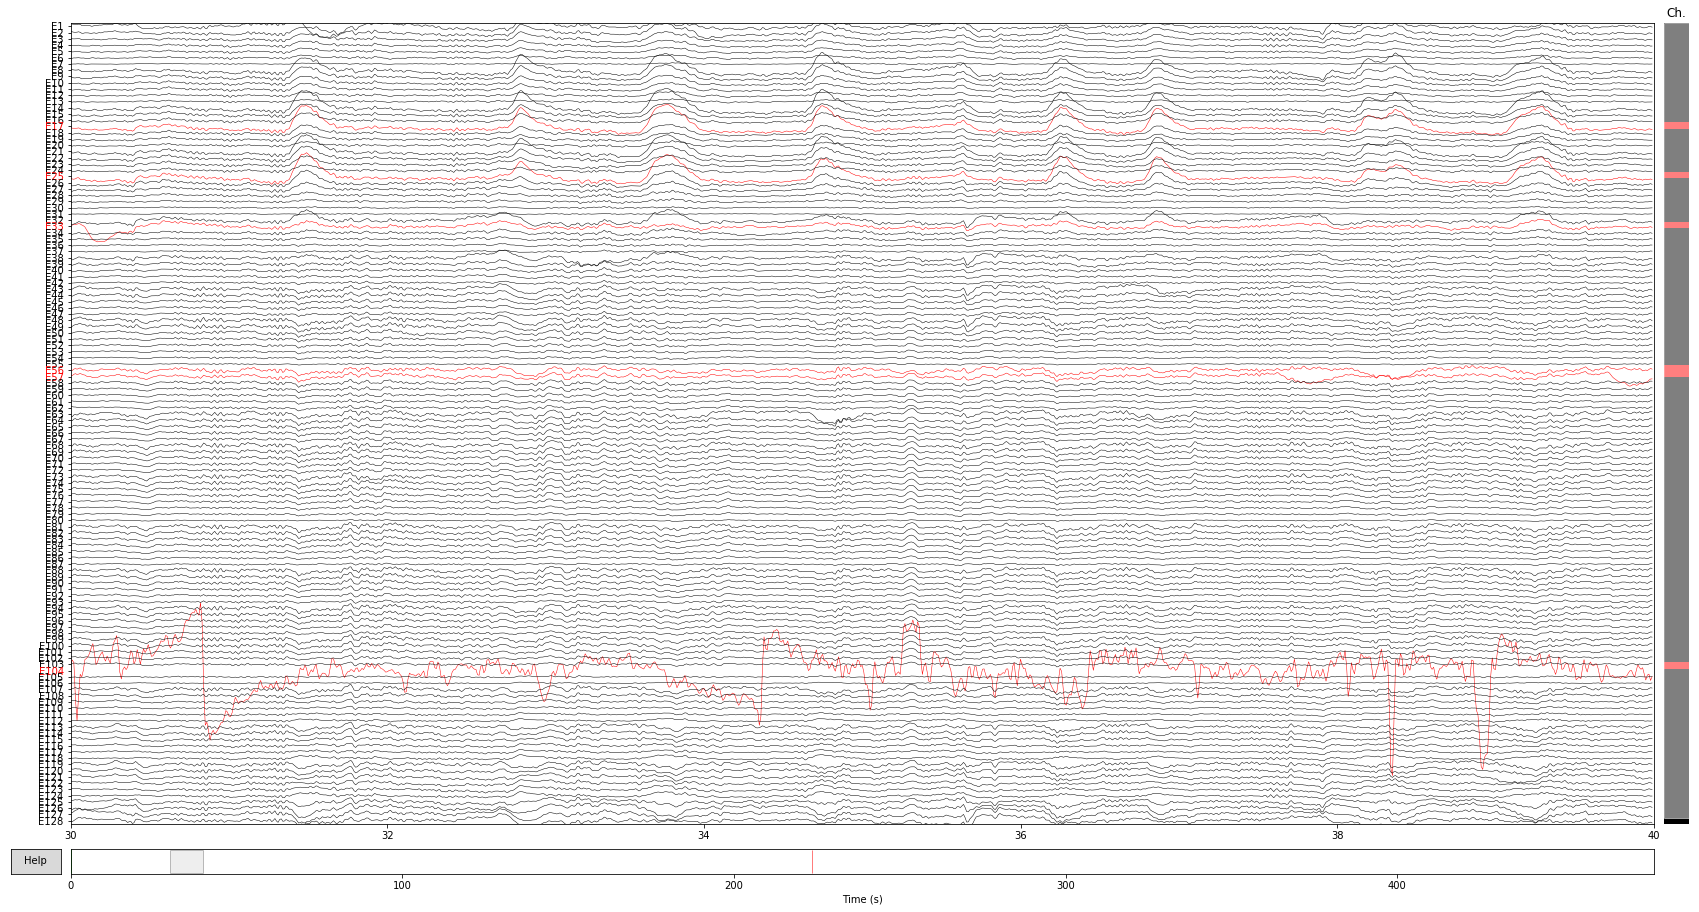

In [16]:
from faster import faster_bad_channels
bad_channels = faster_bad_channels(epochs, thres=5)
raw.info['bads'] = bad_channels
epochs.info['bads'] = bad_channels
print(bad_channels)
raw.plot(events=None, duration=10., start=30., n_channels=128, bad_color='r');

## Remove blink artifacts via ICA

In [20]:
# import and run ica on epochs
from mne.preprocessing import ICA
ica = ICA(random_state=1)
ica.fit(epochs)

Fitting ICA to data using 122 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 122
Fitting ICA took 58.0s.


<ICA  |  epochs decomposition, fit (fastica): 44044 samples, 122 components, channels used: "eeg">

['E8', 'E14', 'E21']


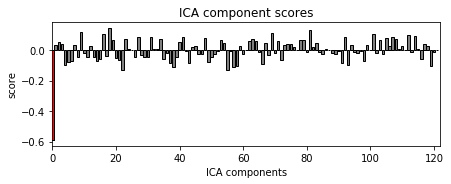

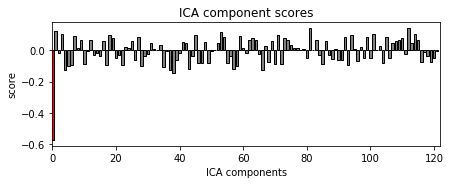

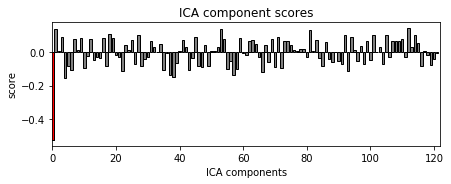

Transforming to ICA space (122 components)
Zeroing out 1 ICA components


In [28]:
# define bad components
eog_chs = ['E8', 'E14','E21','E25']
eog_chs = [ch for ch in eog_chs if ch not in raw.info['bads']]
print(eog_chs)

bad_ica_comps = []
for ch in eog_chs:
    inds, scores = ica.find_bads_eog(raw, ch_name=ch, threshold=2.5, l_freq=1, h_freq=8, verbose=False)
    bad_ica_comps.extend(inds)
    ica.plot_scores(scores, exclude=inds)

bad_ica_comps = list(set(bad_ica_comps))
ica.exclude = bad_ica_comps
epochs = ica.apply(epochs)

### AutoReject

In [33]:
from autoreject import AutoReject

# Initialize autoreject object and run
ar = AutoReject(random_state=1)
epochs, rej_log = ar.fit_transform(epochs, return_log=True)
print(epochs)

Running autoreject on ch_type=eeg


/home/andrew/miniconda2/envs/MIND36/lib/python3.6/site-packages/autoreject/utils.py:64: UserWarning: 6 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  'remove them from epochs.info["bads"].' % n_bads)


[............................................................] 100.00% Creating augmented epochs /   Computing thresholds ...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.9s remaining:   

/home/andrew/miniconda2/envs/MIND36/lib/python3.6/site-packages/autoreject/utils.py:64: UserWarning: 6 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  'remove them from epochs.info["bads"].' % n_bads)


[............................................................] 100.00% Repairing epochs \   <Epochs  |   40 events (all good), -1 - 1 sec, baseline [0.5, None], ~39.7 MB, data loaded,
 'left': 20
 'right': 20>


/home/andrew/miniconda2/envs/MIND36/lib/python3.6/site-packages/autoreject/autoreject.py:1030: UserWarning: No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
  "No bad epochs were found for your data. Returning "


## Save preprocessed epochs object to file

In [35]:
data_path = '/home/andrew/HyperEEG_Data/epochs_preprocessed/'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
filename = data_path + subj + '_preprocessed-epo.fif'
epochs.save(filename)

# Analyses

At this point, the rest becomes specific to the particular analyses that need to be done.

In [ ]:
# Calcualte ERPs
evoked = epochs.average()

In [ ]:
# Plot ERPs
evoked.plot();

In [ ]:
# Check topographies across time
evoked.plot_topomap([-0.1, 0, 0.200, 0.4]);

## Save Out

ToDo: Save out MNE epoch objects.



#### Have: 3D matrix per trial type

#### Options:
- Save out npz files
- Save out MNE object files